# Analysis of CLS and no-filter images

The goal is to find the absorption coefficients of the CLS filter in each one of the RGB bands.

## Method

- 1) Pick two stars: Polaris and a fainter one, defining the subimage where they sit. Pick a nearby sky region.
    - It turned out that Polaris is saturated. I picked two fainter stars nearby.
- 2) Plot RGB debayered version of each subimage. There are 12 files with CLS filter, 7 without.
- 3) Find saturated pixels
    - This can be done either by numerical search, or by plotting the raw arrays and looking at the
      Y scale.
- 4) Iterate until finding the three boxes that encompass two non-saturated stars and the beckground.
- 5) Compute exposure normalization factor for each image.
- 6) Multiply each image by normalization factor.
- 7) Photometry

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import multiprocessing as mp
from multiprocessing import Pool

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import exifread
import rawpy
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


## Utility functions

In [2]:
# Extracts exposure EXIF data from a list of images
def get_metadata(filelist):

    table = Table(names=('ISO', 'Time', 'f/stop', 'Exposure', 'File'), 
                  dtype=('f4','f4','f4','f4','S2'))
    
    exposure_dict = {}

    for filename in filelist:
        f = open(filename, 'rb')
        tags = exifread.process_file(f)
        iso = ''
        exptime = ''
        for tag in tags.keys():
            if tag in ['EXIF ExposureTime']:
                exptime = tags[tag]
            if tag in ['EXIF ISOSpeedRatings']:
                iso = tags[tag]

        index = filename.split('_')[-1].rfind('.')
        fstop = float(filename.split('_')[-1][:index][1:])
        iso = float(str(iso))
        exptime = float(str(exptime))
        
        exposure = exptime/3.2 / iso/100 / fstop/2.8 / 1.E-5
        
        table.add_row((iso, exptime, fstop, exposure, filename))
        
        exposure_dict[filename] = exposure

    return table, exposure_dict

In [3]:
# Functions to support running raw.postprocess in multiprocessor pool

def _run_postprocess(index, filename):
    raw = rawpy.imread(filename)

    # These settings preserve the raw pixel values into the output RGB array.
    rgb = raw.postprocess(
        demosaic_algorithm=0, # linear
        output_bps=16,
        gamma=(1,1), 
        use_camera_wb=False,
        use_auto_wb=False,
        no_auto_bright=True, 
        no_auto_scale=True,
        output_color=rawpy.ColorSpace.raw
    )
    return index, rgb

# Postprocesses all raw files in list
def postprocess(filelist):

    # Build output list with RGB images
    temp_list = []

    # Callback to collect results from workers
    def collect_result(result):
        temp_list.append(result)
        
    # Run multiprocessor pool.
    results = []
    pool = Pool(mp.cpu_count() - 1)

    for index, filename in enumerate(filelist):
        r = pool.apply_async(_run_postprocess, (index,filename,), callback=collect_result)
        results.append(r)
    for r in results:
        r.wait()
    
    # Sort results in the same sequence as the input file names sequence, 
    # using the indices passed to and returned by the workers.  
    output_rgb_list = [i for i in range(len(filelist))]
    for (index, rgb) in temp_list:
        output_rgb_list[index] = rgb
        
    return output_rgb_list

In [4]:
# Plot mosaic with all images from a list
def view_summary(filelist, slicex, slicey, title, nrows=3, ncols=4):

    fig = plt.figure(figsize=[9, 8])
    ax = None
    
    rgblist = postprocess(filelist)

    for i, filename in enumerate(filelist):
        ftitle = filename.split('/')[-1]
        rgb = rgblist[i]
    
        if ax is None:
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_title(ftitle)
        else:
            ax1 = fig.add_subplot(nrows, ncols, i+1, sharex=ax, sharey=ax)
            ax1.set_title(ftitle)

        plt.imshow(rgb[slicey,slicex,1])
        plt.colorbar()

    fig.suptitle(title)
    plt.show()

## Relevant paths for the exposures with and without filter

In [5]:
basepath = '../astrophotography_data/cls/'
without_filter_path = os.path.join(basepath,'without_filter')
with_filter_path = os.path.join(basepath,'with_filter')

list_files_without_filter = glob.glob(without_filter_path + '/*.ARW')
list_files_with_filter = glob.glob(with_filter_path + '/*.ARW')

## Isolate regions of interest

This should be Polaris (not 100% sure it is).

In [6]:
# half-size of box
HSIZE = 17

# Main region (plot)
ry = slice(1960,2060)
rx = slice(2500,2600)

# Bright star  -  THIS IS SATURATED
S0X = 2561
S0Y = 1994
s0y = slice(S0Y-HSIZE, S0Y+HSIZE)
s0x = slice(S0X-HSIZE, S0X+HSIZE)

# Faint star 1
S1X = 2530
S1Y = 1990
s1y = slice(S1Y-HSIZE, S1Y+HSIZE)
s1x = slice(S1X-HSIZE, S1X+HSIZE)

# Faint star 2
S2X = 2567
S2Y = 2029
s2y = slice(S2Y-HSIZE, S2Y+HSIZE)
s2x = slice(S2X-HSIZE, S2X+HSIZE)

# Background
BX = 2537
BY = 2029
by = slice(BY-HSIZE, BY+HSIZE)
bx = slice(BX-HSIZE, BX+HSIZE)

## With filter

<IPython.core.display.Javascript object>


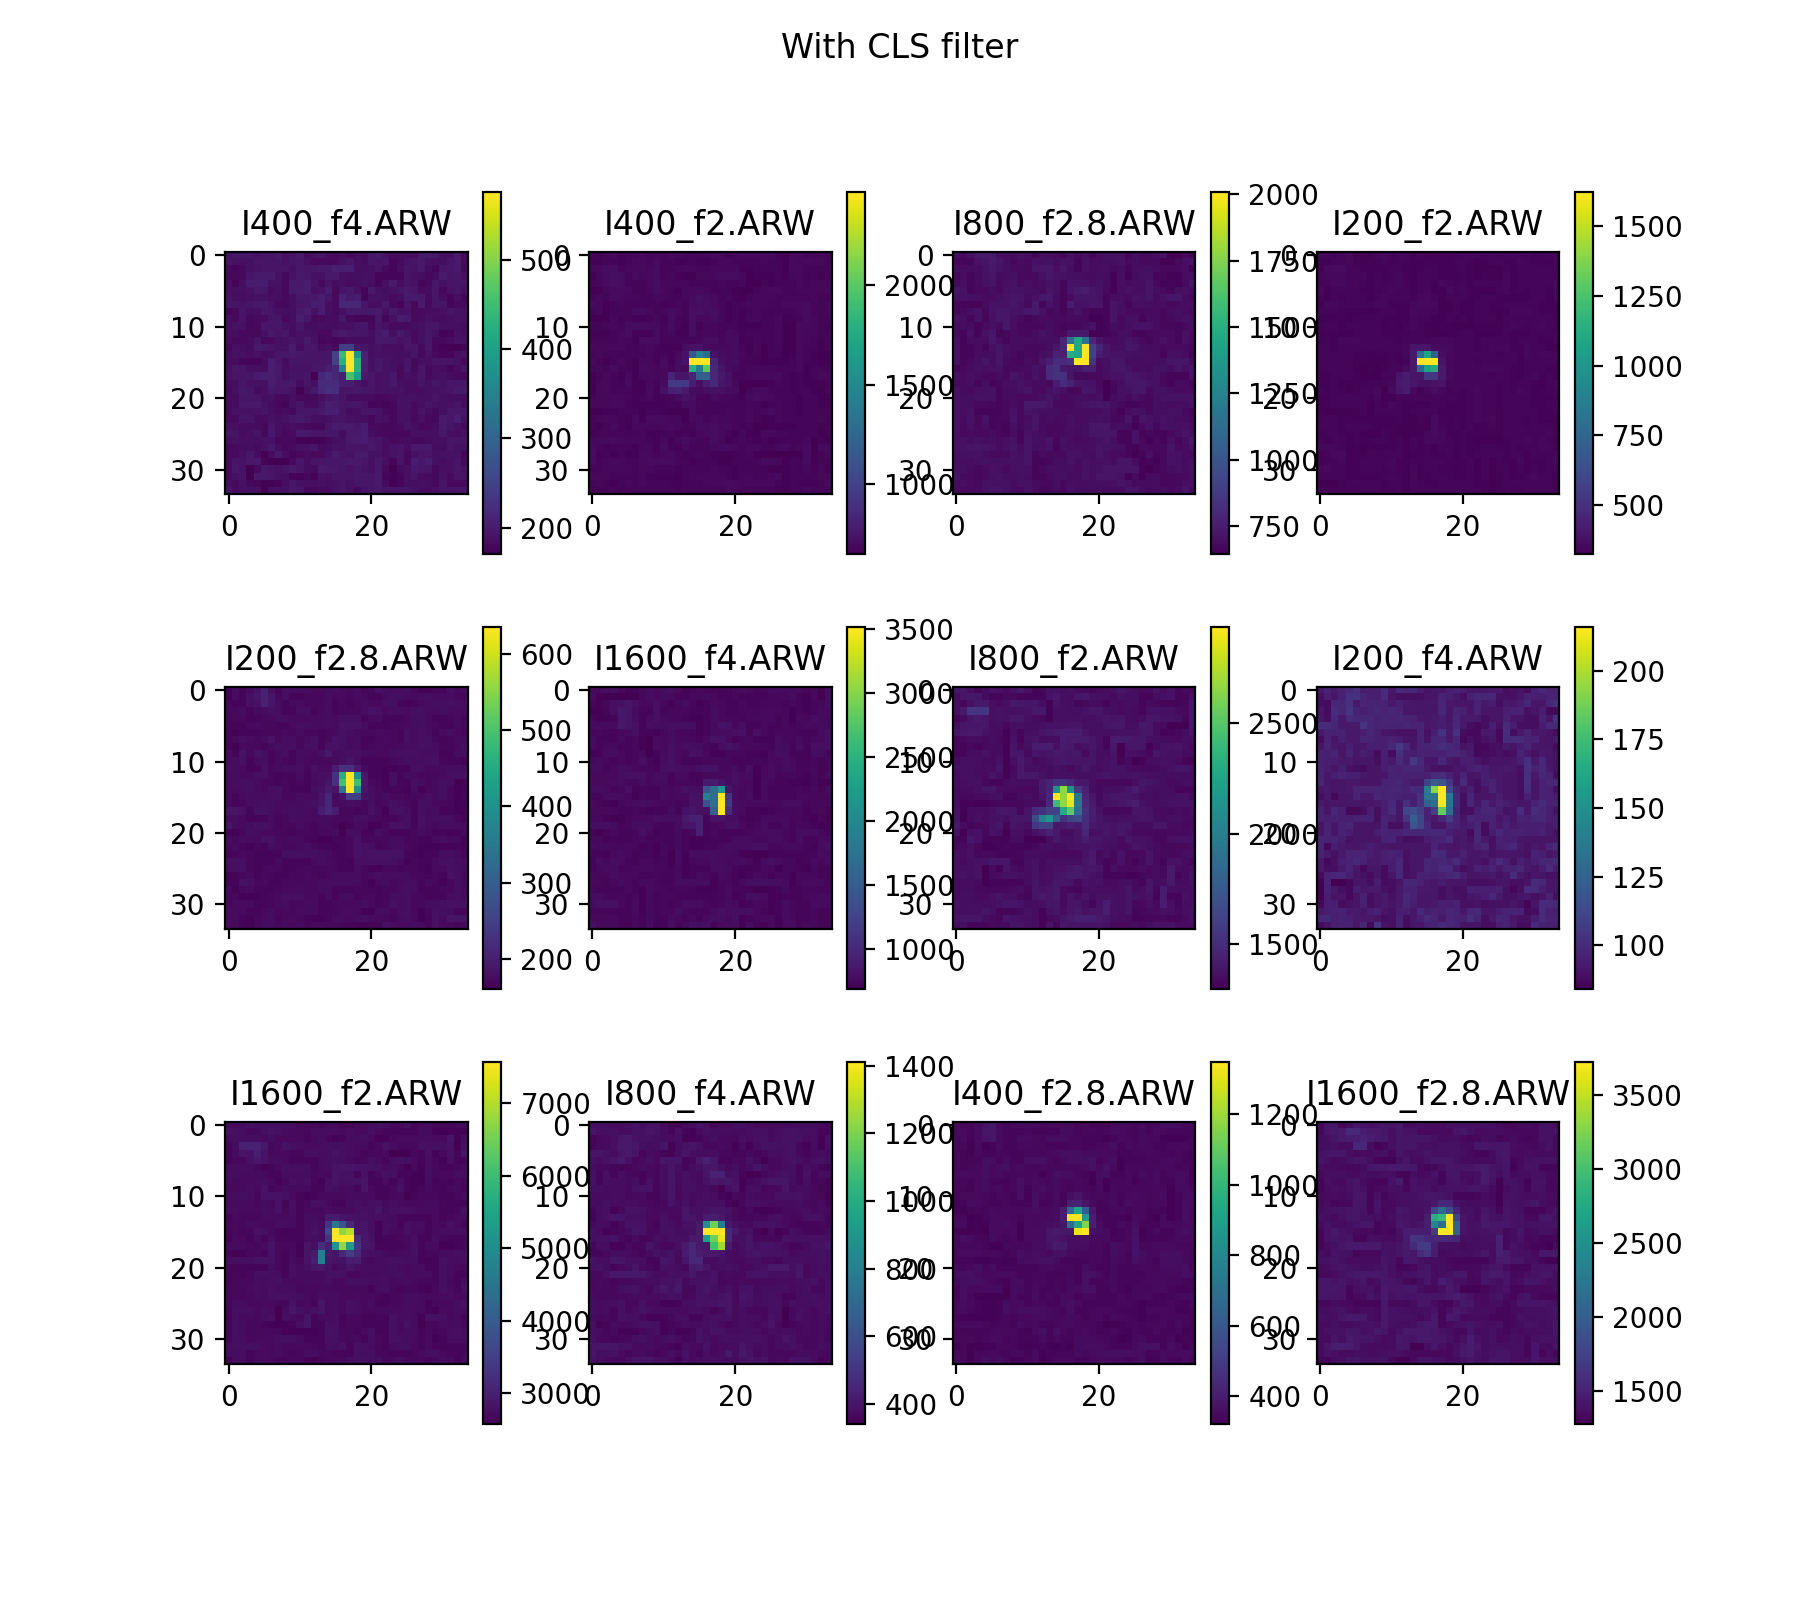

In [7]:
view_summary(list_files_with_filter, s2x, s2y, "With CLS filter")

## Without filter

<IPython.core.display.Javascript object>


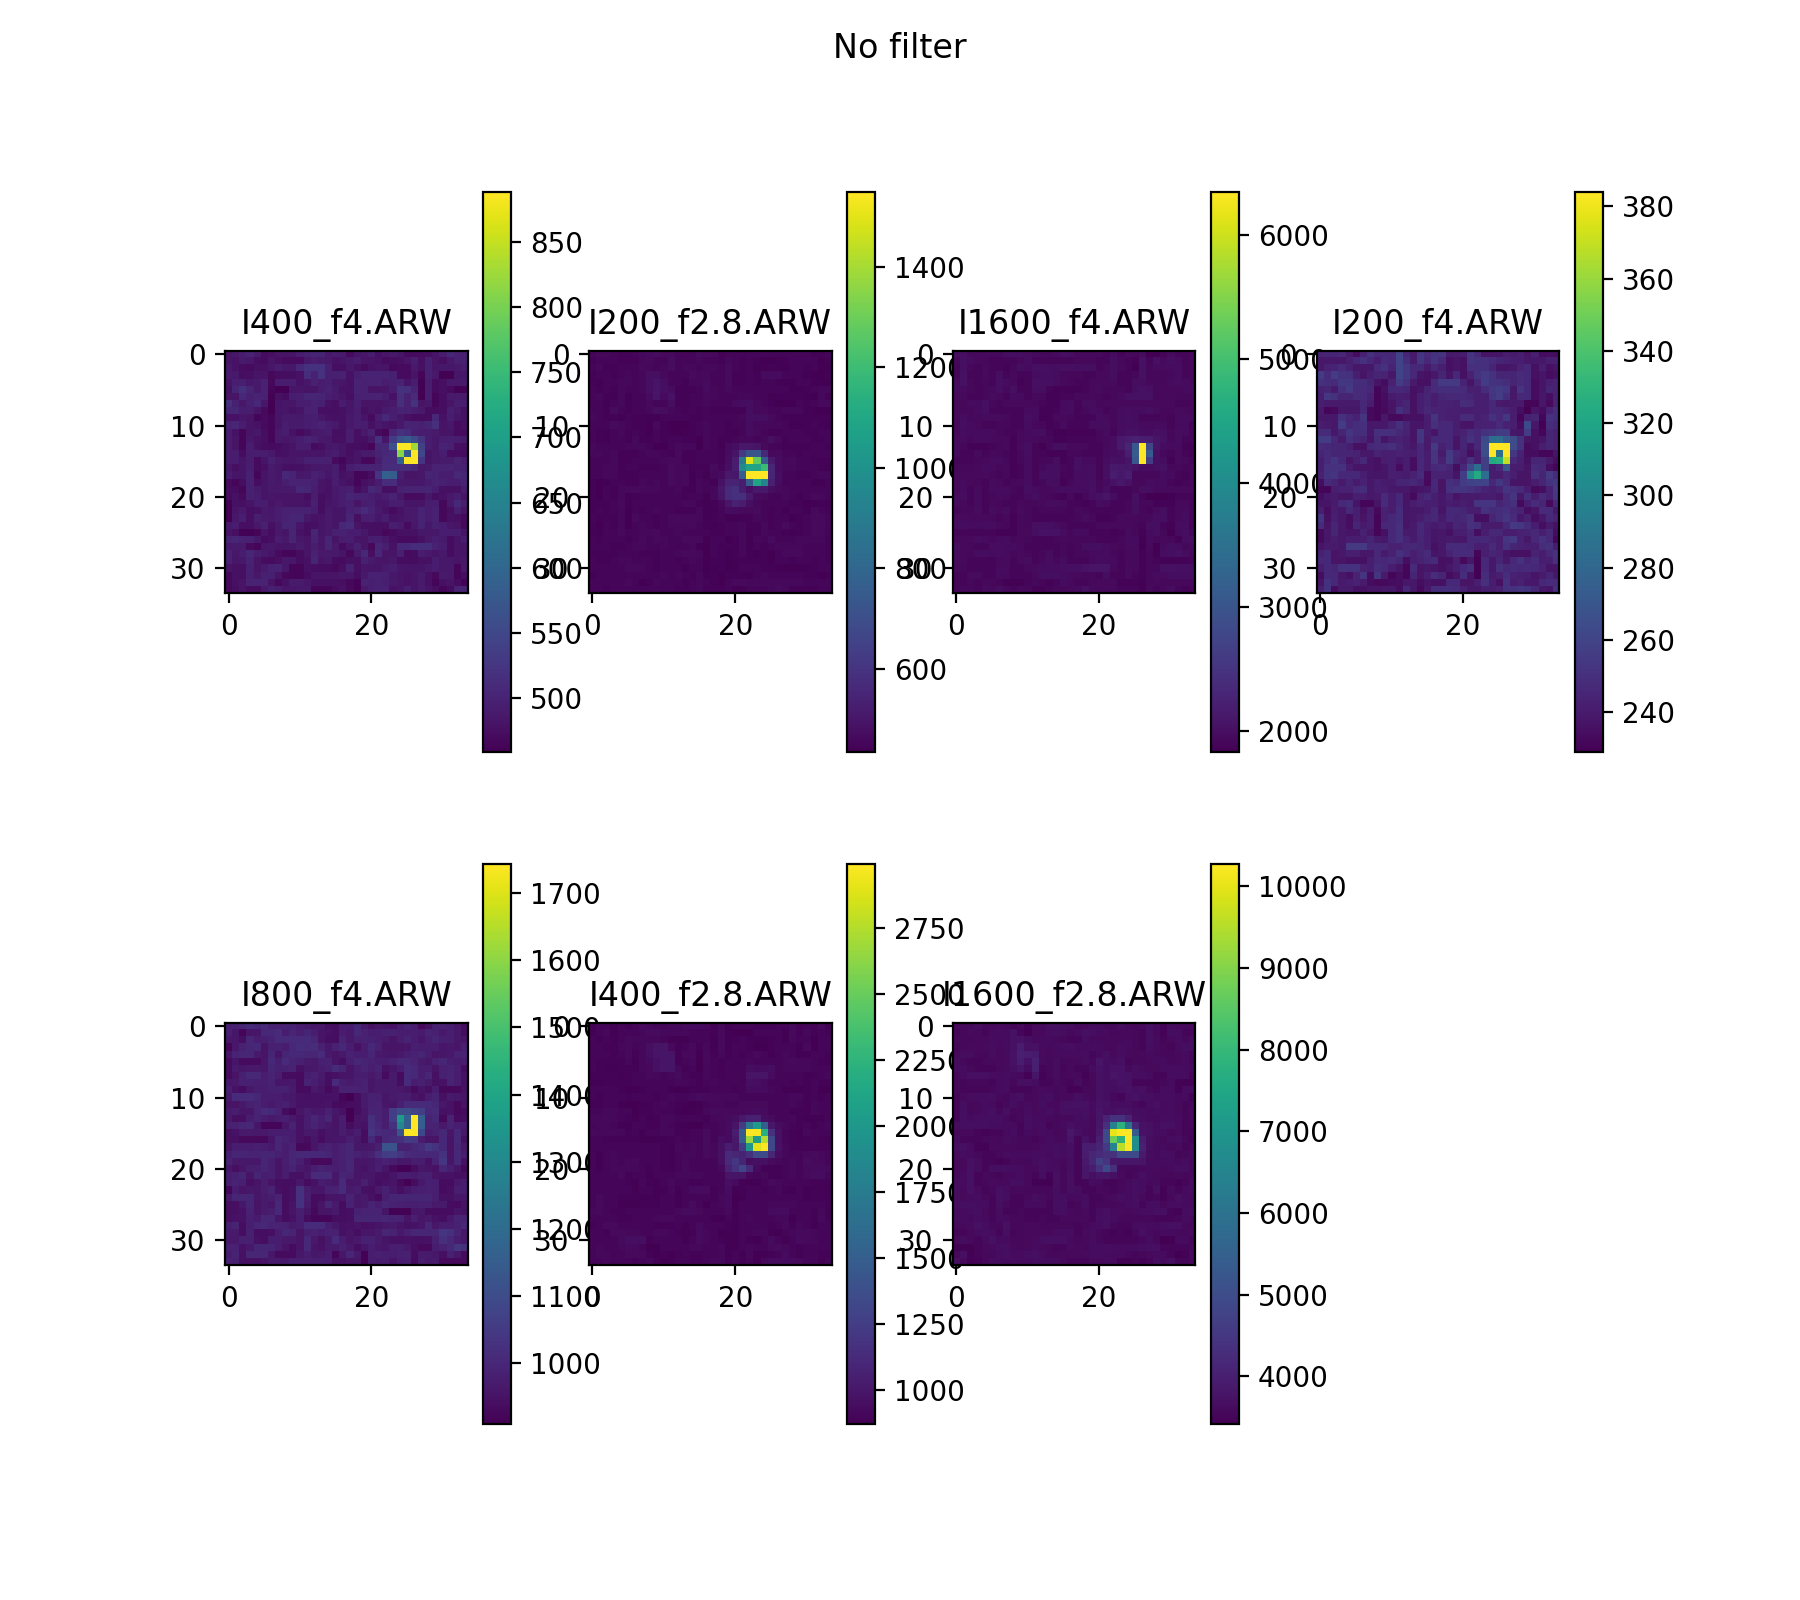

In [8]:
view_summary(list_files_without_filter, s2x, s2y, "No filter", nrows=2)

## EXIF

In [9]:
t1, exp1 = get_metadata(list_files_with_filter)
t2, exp2 = get_metadata(list_files_without_filter)
t1.pprint_all()
t2.pprint_all()

 ISO   Time f/stop  Exposure                           File                         
------ ---- ------ --------- -------------------------------------------------------
 400.0 30.0    4.0  2.092634    ../astrophotography_data/cls/with_filter/I400_f4.ARW
 400.0 30.0    2.0  4.185268    ../astrophotography_data/cls/with_filter/I400_f2.ARW
 800.0 30.0    2.8 1.4947386  ../astrophotography_data/cls/with_filter/I800_f2.8.ARW
 200.0 30.0    2.0  8.370536    ../astrophotography_data/cls/with_filter/I200_f2.ARW
 200.0 30.0    2.8 5.9789543  ../astrophotography_data/cls/with_filter/I200_f2.8.ARW
1600.0 30.0    4.0 0.5231585   ../astrophotography_data/cls/with_filter/I1600_f4.ARW
 800.0 30.0    2.0  2.092634    ../astrophotography_data/cls/with_filter/I800_f2.ARW
 200.0 30.0    4.0  4.185268    ../astrophotography_data/cls/with_filter/I200_f4.ARW
1600.0 30.0    2.0  1.046317   ../astrophotography_data/cls/with_filter/I1600_f2.ARW
 800.0 30.0    4.0  1.046317    ../astrophotography_data/cls/with